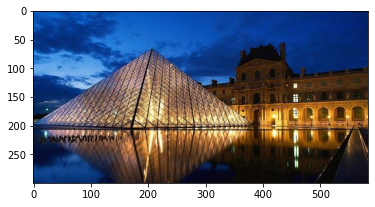

In [1]:
from nst_utils import *

# model = load_vgg_model('pretrained-model/imagenet-vgg-verydeep-19.mat')

content_image = imageio.imread('content_images/architechture.jpg')
imshow(content_image)

In [2]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,(n_H * n_W,n_C))
    a_G_unrolled = tf.reshape(a_G,(n_H * n_W,n_C))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1/(4*n_H*n_W*n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled , a_G_unrolled)))
    ### END CODE HERE ###
    print('***********************************************************************执行多次')
    return J_content

In [3]:
tf.reset_default_graph() 

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

***********************************************************************执行多次
J_content = 6.7655935


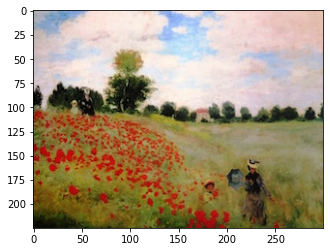

In [4]:
style_image = imageio.imread("style_images/style300.jpg")
imshow(style_image)

In [5]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [7]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S,(n_H*n_W,n_C))
    a_G = tf.reshape(a_G,(n_H*n_W,n_C))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    J_style_layer = 1/(4 * (n_C **2) * ((n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

    return J_style_layer

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)

    print(str(J_style_layer.eval()))

9.190279


In [9]:
# 不同层的不同权重
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [10]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer
    return J_style

In [11]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print(J)

35.34667875478276


In [15]:
%%time
tf.reset_default_graph()
sess = tf.InteractiveSession()

# content_image = imageio.imread('content_images/amber.jpg')
content_image = reshape_and_normalize_image('content_images/amber.jpg')

# style_image = imageio.imread("style_images/style_400x300.jpg")
style_image = reshape_and_normalize_image("style_images/candy.jpg")

generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

model = load_vgg_model('pretrained-model/imagenet-vgg-verydeep-19.mat')

# 计算内容最小损失
sess.run(model['input'].assign(content_image))
out = model['conv4_2']

a_C = sess.run(out)
a_G = out
# print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
# print(a_C)
# print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
# print(a_G)
# print(a_C == a_G)
# print(a_G == out)
# print('//////////////////////////////////////////////////////////////////////////////')
J_content = compute_content_cost(a_C, a_G)

# 计算样式最小损失
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

# 总计最小损失
J = total_cost(J_content, J_style, 10, 40)
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())

    generated_image = sess.run(model['input'].assign(input_image))

    for i in range(num_iterations):
        sess.run(train_step)

        generated_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print('Iterstion' + str(i) + ':')
            print('total_cost = ' + str(Jt))
            print('content_cost = ' + str(J_content))
            print('style_cost = ' + str(J_style))

            save_image(CONFIG.OUTPUT_DIR + str(i) + '.png', generated_image)

        save_image(CONFIG.OUTPUT_DIR + 'gengeated_image.jpg', generated_image)

    return generated_image

model_nn(sess, generated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
conv1_1
conv1_2
conv2_1
conv2_2
conv3_1
conv3_2
conv3_3
conv3_4
conv4_1
conv4_2
conv4_3
conv4_4
conv5_1
conv5_2
conv5_3
conv5_4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[[[[495.36966  154.33488    0.       ...   0.       372.6707
      6.615807]
   [105.112465 488.24313    0.       ...   0.       232.02892
     47.78955 ]
   [ 14.937005 643.33765    0.       ...   0.       288.6316
     29.132963]
   ...
   [ 76.99068  271.70297   38.4085   ...   0.         0.
      0.      ]
   [  0.       240.201    480.13257  ...   0.        56.753216
      0.      ]
   [  0.        80.26561  138.37592  ...   9.140494 255.9142
      0.      ]]

  [[481.90512  111.55813   27.62825  ...   0.       843.51025
      0.      ]
   [  0.       419.49216    0.       ...   0.       848.1565
      0.      ]
   [  0.       869.2441    57.28202  ...   0.       963.386